# `Pytorch-Lighting`

- A high-level framework built on PyTorch that simplifies deep learning model training
- Same code, but extend `pl.LightingModule` instead of `nn.Module`

pl深度学习项目的基本思路:

- 定义`PyTorch Lightning Module`
- 定义`Trainer`
- 调用`Trainer`训练并检验深度学习模块 (Train/Val/Test步骤)

### 1. `def training_step(self, batch, batch_idx):` 每个batch的处理函数:
- **batch** :The output of your DataLoader. A tensor, tuple or list.
- **batch_idx (int)** : Integer displaying index of this batch
- **optimizer_idx (int)** :  When using multiple optimizers, this argument will also be present.
- **hiddens (Tensor)** :  Passed in if truncated_bptt_steps > 0.
- **返回值**: Tensor(The loss tensor) ***OR*** A dictionary (can include any keys, but must include the key 'loss')
```python
def training_step(self, batch, batch_idx):
    x, y, z = batch
    out = self.encoder(x)
    loss = self.loss(out, x)
    return loss

# Multiple optimizers (e.g.: GANs)
def training_step(self, batch, batch_idx, optimizer_idx):
    if optimizer_idx == 0:
        # do training_step with encoder
    if optimizer_idx == 1:
        # do training_step with decoder
```

### 2. `configure_optimizers`

优化器定义, 返回一个优化器, 或数个优化器, 或两个List(优化器, Scheduler)

```python
# most cases
def configure_optimizers(self):
    opt = Adam(self.parameters(), lr=1e-3)
    return opt

# multiple optimizer case (e.g.: GAN)
def configure_optimizers(self):
    generator_opt = Adam(self.model_gen.parameters(), lr=0.01)
    disriminator_opt = Adam(self.model_disc.parameters(), lr=0.02)
    return generator_opt, disriminator_opt

# example with learning rate schedulers
def configure_optimizers(self):
    generator_opt = Adam(self.model_gen.parameters(), lr=0.01)
    disriminator_opt = Adam(self.model_disc.parameters(), lr=0.02)
    discriminator_sched = CosineAnnealing(discriminator_opt, T_max=10)
    return [generator_opt, disriminator_opt], [discriminator_sched]

# example with step-based learning rate schedulers
def configure_optimizers(self):
    gen_opt = Adam(self.model_gen.parameters(), lr=0.01)
    dis_opt = Adam(self.model_disc.parameters(), lr=0.02)
    gen_sched = {'scheduler': ExponentialLR(gen_opt, 0.99),
                 'interval': 'step'}  # called after each training step
    dis_sched = CosineAnnealing(discriminator_opt, T_max=10) # called every epoch
    return [gen_opt, dis_opt], [gen_sched, dis_sched]

# example with optimizer frequencies
# see training procedure in `Improved Training of Wasserstein GANs`, Algorithm 1
# https://arxiv.org/abs/1704.00028
def configure_optimizers(self):
    gen_opt = Adam(self.model_gen.parameters(), lr=0.01)
    dis_opt = Adam(self.model_disc.parameters(), lr=0.02)
    n_critic = 5
    return (
        {'optimizer': dis_opt, 'frequency': n_critic},
        {'optimizer': gen_opt, 'frequency': 1}
    )
```
### 3. Other Moduls

- **forward:** 和正常的`nn.Module`一样, 用于inference. 内部调用时: `y=self(batch)`
- **training_step_end**: 只在使用多个node进行训练且结果涉及如softmax之类需要全部输出联合运算的步骤时使用该函数. 同理, `validation_step_end`/`test_step_end`
- **training_epoch_end**: 在一个训练**epoch**结尾处被调用. 
    - 输入参数: 一个List, List的内容是前面`training_step()`所返回的每次的内容. 
    - 返回: None

- **validation_step(self, batch, batch_idx)/test_step(self, batch, batch_idx):**
    - 没有返回值限制, 不一定非要输出一个val_loss.

- **validation_epoch_end/test_epoch_end**

### 4. Template

```python
class LitModel(pl.LightningModule):

    def __init__(...):

    def forward(...):

    def training_step(...)

    def training_step_end(...)

    def training_epoch_end(...)

    def validation_step(...)

    def validation_step_end(...)

    def validation_epoch_end(...)

    def test_step(...)

    def test_step_end(...)

    def test_epoch_end(...)

    def configure_optimizers(...)

    def any_extra_hook(...)
```

```python
"""Trainer"""
model = MyLightningModule()

trainer = Trainer()
trainer.fit(model, train_dataloader, val_dataloader)
"""
注意: 如果连validation_step都没有，那val_dataloader也就算了
"""

```

### 5. 加载训练好的模型进行推理
```python
# load the model  
CHECKPOINT_PATH = 'lightning_logs/version_9/checkpoints/epoch=59-step=120000.ckpt'  
TEMP_VIDEO_PATH = 'tmp_video'  
MODEL_TYPE = 'slowfast'  
classifier = SignLanguageClassifier.load_from_checkpoint(CHECKPOINT_PATH, strict=False, model_type=MODEL_TYPE)  
classifier.model_type = MODEL_TYPE  
trainer = pl.Trainer()

# make inference 
trainer.test(classifier, test_dataloader)
```

### 6. 实战模板-1

在 `FashionMNIST` 进行图片分类

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F 
import torchmetrics

训练集样本数: 60000, 测试集样本数: 10000
____________________________________
第一个数据大小: torch.Size([1, 28, 28])
第一个数据对应标签: 9
____________________________________


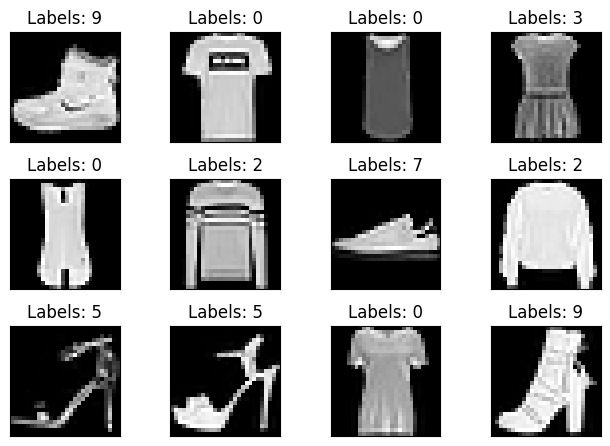

In [45]:
# Load data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


fmnist_train = torchvision.datasets.FashionMNIST(
    root="../Data/FMNIST", train=True, transform=transform, download=True
)

fmnist_test = torchvision.datasets.FashionMNIST(
    root="../Data/FMNIST", train=False, transform=transform, download=True
)

print(f'训练集样本数: {len(fmnist_train)}, 测试集样本数: {len(fmnist_test)}')
print("____________________________________")

# See the 1st training data
img, target = fmnist_test[0]
print(f'第一个数据大小: {img.shape}')
print(f'第一个数据对应标签: {target}')

print("____________________________________")

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    # plt.imshow(fmnist_train.data[i], cmap='gray', interpolation='none')
    plt.imshow(fmnist_train[i][0].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(fmnist_train.targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [47]:
# creat dataLoaders
batch_size = 64

#train_loader = DataLoader(dataset=fmnist_train,batch_size=batch_size,shuffle=True,num_workers=0, drop_last=True)
#test_loader = DataLoader(dataset=fmnist_test,batch_size=batch_size,shuffle=True,num_workers=0, drop_last=True)

train_loader = DataLoader(dataset=fmnist_train,batch_size=batch_size,shuffle=True,num_workers=2,persistent_workers=True, drop_last=True)
test_loader = DataLoader(dataset=fmnist_test,batch_size=batch_size,shuffle=True,num_workers=2,persistent_workers=True, drop_last=True)

In [67]:
for i, batch in enumerate(train_loader):
    """ 
    每一个batch是一个list, 
    batch[0]: 储存了64 (batch_size) 个数据的tensor
    batch[1]: 储存了64 (batch_size) 个数据对应标签的tensor
    """
    if i <=1:
        data, label = batch
        #print(label)
        print(f'第{i}个batch的数据形状是: {data.size()}')
        print(f'第{i}个batch的数据形状是: {batch[0].size()}')
        print("____________________________________")
        
    else:
        break

第0个batch的数据形状是: torch.Size([64, 1, 28, 28])
第0个batch的数据形状是: torch.Size([64, 1, 28, 28])
____________________________________
第1个batch的数据形状是: torch.Size([64, 1, 28, 28])
第1个batch的数据形状是: torch.Size([64, 1, 28, 28])
____________________________________


In [ ]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image， 这里变换前 x 的形状为x [64, 1, 28, 28]， 变换后为 [64, 28*28]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def training_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)                 # Logits (raw outputs)
        loss = self.criterion(outputs, y_batch) # Loss
        preds = torch.argmax(outputs, dim=1)    # Predictions
        acc = self.accuracy(preds, y_batch)
        self.log("train_loss", loss, sync_dist=True) # sync_dist=True 表示在分布式训练中同步这些指标
        self.log("train_acc", acc, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, y_batch)
        self.log("val_loss", loss, sync_dist=True, on_epoch=True)
        self.log("val_acc", acc, sync_dist=True, on_epoch=True)
        return loss
    
    def on_train_epoch_end(self):
        """ 
        self.trainer: 这是指当前模型的训练器(rainer) 对象, 负责管理训练过程, 包括训练,验证和测试
        self.trainer.callback_metrics: 这是一个字典, 包含在训练过程中收集的各种指标. 这些指标通常由回调函数(callbacks)更新, 并可以在训练期间访问
        """
        avg_loss = self.trainer.callback_metrics["train_loss"].item()
        avg_acc = self.trainer.callback_metrics["train_acc"].item()
        print(f"Epoch {self.trainer.current_epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}")
    
    def on_validation_epoch_end(self):
        avg_loss = self.trainer.callback_metrics["val_loss"].item()
        avg_acc = self.trainer.callback_metrics["val_acc"].item()

    def configure_optimizers(self):
        return optim.RMSprop(self.parameters(), lr=0.001, momentum=0.0)

model = NeuralNetwork()   

In [64]:
from pytorch_lightning.utilities.model_summary import ModelSummary
ModelSummary(model, max_depth=2) # 设置为 2 表示只显示模型的前两层及其子层的详细信息，但是如果模型简单依然会显示所有层

  | Name      | Type               | Params
-------------------------------------------------
0 | fc1       | Linear             | 401 K 
1 | fc2       | Linear             | 262 K 
2 | fc3       | Linear             | 5.1 K 
3 | criterion | CrossEntropyLoss   | 0     
4 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
669 K     Trainable params
0         Non-trainable params
669 K     Total params
2.679     Total estimated model params size (MB)

In [39]:
import logging # Cleaner output
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

accelerator = "cpu"
if torch.backends.mps.is_available():
    accelerator = "mps"
if torch.cuda.is_available():
    accelerator = "gpu"

In [40]:
# pl.Trainer: 这是 PyTorch Lightning 提供的一个类，负责管理训练过程的各个方面，如训练、验证、日志记录等
trainer = pl.Trainer(max_epochs=3, accelerator=accelerator)
trainer.fit(model, train_loader)

Epoch 2: 100%|██████████| 937/937 [00:05<00:00, 158.02it/s, v_num=1]


In [ ]:
from pytorch_lightning.callbacks import Callback  # yTorch Lightning 提供的基类，用于创建自定义回调
from IPython.display import clear_output  # 用于在 Jupyter Notebook 中清除输出，以便于实时更新图表

# First try. Not very efficient yet.
class TrainingBatchPlotCallback(Callback):
    def __init__(self, update_interval=100, smoothing=100):
        """
        Callback to plot training and validation progress.

        Args:
            update_interval (int): Number of batches between updates.  每多少个批次更新一次图表
            smoothing (int): Window size for moving average. 移动平均窗口大小, 用于平滑曲线
        """
        super().__init__()
        self.update_interval = update_interval
        self.smoothing = smoothing
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.val_x_positions = []  # Store x positions for validation scores,  存储验证得分的 x 轴位置
        self.max_acc = 0   # 记录最高验证准确率
        self.global_step = 0  # Tracks processed training batches
        self.epoch_count = 0  # Tracks processed epochs
        self.steps_per_epoch = 0  # Updated dynamically to track num_batches per epoch

    def moving_average(self, values, window):
        """
        Computes a simple moving average for smoothing.
        计算简单的移动平均, 用于平滑损失和准确率曲线
        """
        if len(values) < window:
            return np.convolve(values, np.ones(len(values)) / len(values), mode="valid")
        return np.convolve(values, np.ones(window) / window, mode="valid")

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Updates training loss and accuracy every `update_interval` batches."""
        self.global_step += 1
        logs = trainer.callback_metrics

        # Store training loss and accuracy
        if "train_loss" in logs:
            self.losses.append(logs["train_loss"].item())
        if "train_acc" in logs:
            self.acc.append(logs["train_acc"].item())

        # Update plot every `update_interval` training batches
        if self.global_step % self.update_interval == 0:
            self.plot_progress()

    def on_validation_epoch_end(self, trainer, pl_module):
        """Updates validation loss and accuracy at the end of each epoch, scaling x-axis correctly."""
        logs = trainer.callback_metrics
        self.epoch_count += 1
        if self.steps_per_epoch == 0:
            self.steps_per_epoch = self.global_step

        self.val_x_positions.append(self.global_step)

        # Retrieve validation metrics from trainer
        if "val_loss" in logs:
            self.val_losses.append(logs["val_loss"].item())
        if "val_acc" in logs:
            val_acc = logs["val_acc"].item()
            self.val_acc.append(val_acc)
            self.max_acc = max(self.max_acc, val_acc)
            
    def on_train_end(self, trainer, pl_module):
        """Ensures the final validation curve is plotted after the last epoch."""
        self.plot_progress()
            
    def plot_progress(self):
        """Plots training and validation metrics with moving averages."""
        clear_output(wait=True)
        steps = np.arange(1, len(self.losses) + 1)

        plt.figure(figsize=(8, 4))
        plt.ylim(0, 1)  # Constrain y-axis between 0 and 1

        # Training curves
        plt.plot(steps / self.steps_per_epoch, self.losses, lw=0.2, alpha=0.3, c="b", linestyle="-")
        plt.plot(steps / self.steps_per_epoch, self.acc, lw=0.2, alpha=0.3, c="r", linestyle="-")

        # Moving average (thicker line)
        if len(self.losses) >= self.smoothing:
            plt.plot(steps[self.smoothing - 1:] / self.steps_per_epoch, self.moving_average(self.losses, self.smoothing),
                     lw=1, c="b", linestyle="-", label="Train Loss")
        if len(self.acc) >= self.smoothing:
            plt.plot(steps[self.smoothing - 1:] / self.steps_per_epoch, self.moving_average(self.acc, self.smoothing),
                     lw=1, c="r", linestyle="-", label="Train Acc")

        # Validation curves (scaled to correct x-positions)
        if self.val_losses:
            plt.plot(np.array(self.val_x_positions) / self.steps_per_epoch, self.val_losses, c="b", linestyle=":", label="Val Loss", lw=2)
        if self.val_acc:
            plt.plot(np.array(self.val_x_positions) / self.steps_per_epoch, self.val_acc, c="r", linestyle=":", label="Val Acc", lw=2)

        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Loss/Accuracy", fontsize=12)
        plt.title(f"Training Progress (Step {self.global_step}, Epoch {self.epoch_count}, Max Val Acc {self.max_acc:.4f})", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(fontsize=10)
        plt.show()

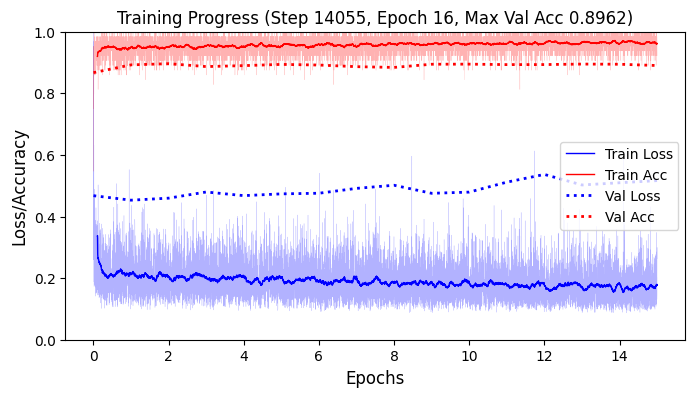

In [68]:
# enable_progress_bar=False: 禁用训练过程中的进度条显示
trainer = pl.Trainer(
    max_epochs=15,
    enable_progress_bar=False,
    accelerator=accelerator,
    callbacks=[TrainingBatchPlotCallback()] # Attach the callback
)
trainer.fit(model, train_loader, test_loader)

### 7. 实战模板-2

图片分类代码, 对整个数据集进行5折交叉验证后汇报平均准确率和混淆矩阵. 这个代码可以很直观地体现出PL的逻辑和整体流程.

In [ ]:
"""  
a Python script to train ResNet-18 using PyTorch Lightning. The dataset includes 5 categories.  
Report the classification accuracy and confusion matrix with torch-metrics.  
  
Use 5-fold stratified sampling.  
Report the final average classification accuracies at the end of the program.  
"""  
  
  
import numpy as np  
import pytorch_lightning as pl  
from pytorch_lightning.loggers import TensorBoardLogger  
import torch  
from torch.nn import functional as F  
from torch.utils.data import DataLoader, TensorDataset  
from torchvision import models, transforms  
import torchmetrics  
from sklearn.model_selection import StratifiedKFold  
import seaborn  
import matplotlib.pyplot as plt  
  
  
MAX_EPOCH = 100  
  
  
class Classifier(pl.LightningModule):  
    def __init__(self, num_classes: int, model_type: str = 'resnet18'):  
        super().__init__()  
        self.model_type = model_type  
        if model_type == 'resnet18':  
            self.model = models.resnet18(pretrained=True)  
            self.model.fc = torch.nn.Sequential(  
                    torch.nn.Linear(self.model.fc.in_features, 128),  
                    torch.nn.ReLU(),  
                    torch.nn.Linear(128, 64),  
                    torch.nn.ReLU(),  
                    torch.nn.Linear(64, num_classes)  
                    )  
        elif model_type == 'mlp':  
            self.model = torch.nn.Sequential(  
                torch.nn.Linear(40, 128),  
                torch.nn.ReLU(),  
                torch.nn.Linear(128, 64),  
                torch.nn.ReLU(),  
                torch.nn.Linear(64, num_classes)  
            )  
        else:  
            raise ValueError(f'Invalid model_type: {model_type}')  
        self.accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes)  
        self.conf_mat = torchmetrics.classification.MulticlassConfusionMatrix(num_classes, normalize='true')  
  
    def forward(self, x):  
        if self.model_type == 'resnet18':  
            x = x.view(x.size(0), 1, -1, 1)    # Reshape 1D data into a single-channel "image"  
            x = torch.repeat_interleave(x, repeats=3, dim=1)  
        return self.model(x.float())  
  
    def training_step(self, batch, batch_idx):  
        x, y = batch  
        y_hat = self(x)  
        loss = F.cross_entropy(y_hat, y.long())  
        self.log('train_loss', loss, )  
        return loss  
  
    def validation_step(self, batch, batch_idx):  
        x, y = batch  
        y_hat = self(x)  
        self.log('val_accuracy', self.accuracy, on_epoch=True, prog_bar=True)  
        self.log('val_loss', F.cross_entropy(y_hat, y.long()), on_step=True, prog_bar=True)  
        self.conf_mat.update(y_hat, y)  
        self.accuracy.update(y_hat, y)  
  
    def on_validation_end(self):  
        conf_matrix = self.conf_mat.compute()  
        print(conf_matrix)  
        plt.figure()  
        seaborn.heatmap(conf_matrix.cpu(), annot=True)  
        plt.savefig(f'conf_mat_{fold_id}.png')  
        accuracy_computed = self.accuracy.compute()  
        print(f'Fold Accuracy={accuracy_computed}')  
  
    def configure_optimizers(self):  
        return torch.optim.Adam(self.parameters(), lr=0.00001)  
  
# Load data and labels from .npy file  
data_and_labels = np.load('data/data_and_labels.npy', allow_pickle=True).item()  
X = data_and_labels['X']  
y = data_and_labels['y']  
  
# Prepare 5-fold stratified sampling  
skf = StratifiedKFold(n_splits=5, shuffle=True)  
  
# Initialize list for storing classification accuracies  
accuracies = []  
fold_id = 0  
# Perform 5-fold stratified sampling  
for train_index, val_index in skf.split(X, y):  
    X_train, X_val = X[train_index], X[val_index]  
    y_train, y_val = y[train_index], y[val_index]  
  
    # Create TensorDatasets  
    train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))  
    val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))  
  
    # Create DataLoaders  
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  
    val_loader = DataLoader(val_data, batch_size=64)  
  
    # Model  
    model = Classifier(num_classes=5)  
  
    # Training  
    tensorboard_logger = TensorBoardLogger(save_dir='.', version=fold_id)  
    trainer = pl.Trainer(max_epochs=MAX_EPOCH, devices='auto', accelerator='auto', logger=tensorboard_logger)  
    trainer.fit(model, train_loader, val_loader)  
  
    fold_id += 1